In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import scipy.interpolate
from scipy.ndimage import gaussian_filter
import tifffile
import seaborn as sns

from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.notebook import tqdm, trange
from scipy.optimize import curve_fit
#import gaussian
from skimage.filters import gaussian
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import itertools




In [9]:
PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#movie = 'Control'
#movie = '130721'
#movie ='140721'
#movie ='150721'
#movie ='100621'
movie ='280523 AM100 568'
ADD_PATH = os.path.join(PROJECT_PATH, "add_data/")


MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'

In [11]:
gel = np.load(MOVIE_PATH + 'np/gel.npy', mmap_mode='r')


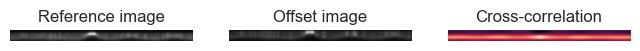

Detected pixel offset (y, x): [5. 1.]


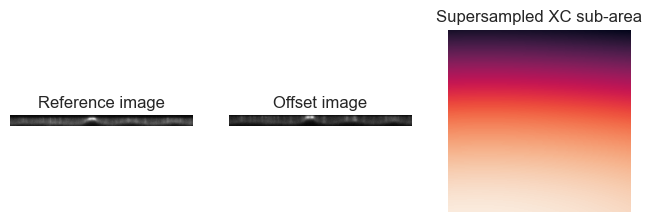

Detected subpixel offset (y, x): [5.04 1.51]


In [14]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = gel[4][0:30,256,:].copy()

#shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
#offset_image = fourier_shift(np.fft.fftn(image), shift)
#offset_image = np.fft.ifftn(offset_image)
offset_image = gel[12][0:30,256,:].copy()
image[np.isnan(image)] = 0
offset_image[np.isnan(offset_image)] = 0
#print(f'Known offset (y, x): {shift}')

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Detected subpixel offset (y, x): {shift}')

In [100]:
#import sobel
images = gel[:,:,256,:]
image = sobel(images)
zmin=4
zmax=19
cumshift = np.zeros((len(gel),2))
cumshift[0,:] = [0,0]

for t in range(1,len(gel)):
    image = images[0].copy()
    offset_image = images[t].copy()


    image[np.isnan(image)] = 0
    offset_image[np.isnan(offset_image)] = 0


    # pixel precision first
    shift, error, diffphase = phase_cross_correlation(image, offset_image, upsample_factor=100)
    cumshift[t] = shift
    '''fig, (ax1,ax2) = plt.subplots(2,1)
    ax1.imshow(image)
    ax2.imshow(offset_image)
    plt.tight_layout()
    plt.suptitle('t = ' + str(t))
    plt.show()'''



In [90]:
import numpy as np
from skimage import io, transform

def translate_image_skimage(image, y_shift, x_shift):
    tform = transform.AffineTransform(translation=(x_shift, y_shift))
    return transform.warp(image, tform, mode='edge')

# Sample data
# Assuming images is a list of numpy arrays
images = gel[:,:,256,:].copy()

translated_images = [translate_image_skimage(img, -y, 0) for img, y in zip(images, cumshift[:,0])]

# Now translated_images contains the shifted images.


In [ ]:
#save translated images to tiff
tifffile.imsave(MOVIE_PATH + 'np/gel_translated.tif', translated_images)


In [102]:
#import sobel
images = np.array(translated_images)
images[:,23:,:] = 0
cumshift2 = np.zeros((len(gel),2))
cumshift2[0,:] = [0,0]

for t in range(1,len(gel)):
    image = images[0].copy()
    offset_image = images[t].copy()


    image[np.isnan(image)] = 0
    offset_image[np.isnan(offset_image)] = 0


    # pixel precision first
    shift, error, diffphase = phase_cross_correlation(image, offset_image, upsample_factor=100)
    cumshift2[t] = shift
    '''fig, (ax1,ax2) = plt.subplots(2,1)
    ax1.imshow(image)
    ax2.imshow(offset_image)
    plt.tight_layout()
    plt.suptitle('t = ' + str(t))
    plt.show()'''


In [107]:
import numpy as np
from skimage import io, transform

def translate_image_skimage(image, y_shift, x_shift):
    tform = transform.AffineTransform(translation=(x_shift, y_shift))
    return transform.warp(image, tform, mode='edge')

# Sample data
# Assuming images is a list of numpy arrays

final_translated_images = [translate_image_skimage(img, -y, 0) for img, y in zip( gel[:,:,256,:].copy(), cumshift[:,0]+cumshift2[:,0])]

# Now translated_images contains the shifted images.


In [108]:
#save translated images to tiff
tifffile.imsave(MOVIE_PATH + 'np/gel_translated_twice.tif',final_translated_images)


In [38]:
tifffile.imsave(MOVIE_PATH + 'np/gel_original.tif', gel[:,:,256,:])


In [32]:
list(zip(images, cumshift[:,0]))

[(array([[120., 113., 125., ..., 110., 111., 112.],
         [121., 118., 115., ..., 114., 115., 117.],
         [117., 111., 120., ..., 116., 114., 120.],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),
  0.0),
 (array([[115., 108., 121., ..., 118., 114., 113.],
         [117., 113., 116., ..., 114., 116., 112.],
         [125., 114., 116., ..., 125., 110., 122.],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),
  0.49),
 (array([[118., 111., 115., ..., 115., 114., 121.],
         [125., 112., 115., ..., 113., 120., 113.],
         [118., 119., 123., ..., 122., 117., 123.],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),

In [109]:
import SimpleITK as sitk

def register_3D_images(fixed_image, moving_image):
    # Initial alignment using CenteredTransformInitializer
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image, moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    # Setting up the registration method
    registration_method = sitk.ImageRegistrationMethod()

    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(fixed_image, moving_image)

    # Resampling the moving image
    resampled_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

    return resampled_image

# Load your 3D images
fixed_image = sitk.GetImageFromArray(gel[4])  # Change path accordingly
moving_image = sitk.GetImageFromArray(gel[12])  # Change path accordingly

# Register
registered_image = register_3D_images(fixed_image, moving_image)

# If you want to save the result
reg_npy = sitk.GetArrayFromImage(registered_image)

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: c:\miniconda\envs\bld\conda-bld\work\b\itk-prefix\include\itk-5.3\itkMattesMutualInformationImageToImageMetricv4.hxx:315:
ITK ERROR: MattesMutualInformationImageToImageMetricv4(000002372F8444A0): Joint PDF summed to zero

In [115]:
import ants
import numpy as np

# Assuming you have two numpy arrays: fixed_image_array and moving_image_array
source = gel[0].copy()
source[np.isnan(source)] = 0
# Convert numpy arrays to ANTs images
fixed_image = ants.from_numpy(source)
moving_image = ants.from_numpy(gel[14])

# Perform the registration
registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='SyN')

# Warp the moving image to the space of the fixed image
warped_moving_image = ants.apply_transforms(fixed=fixed_image, moving=moving_image,
                                            transformlist=registration['fwdtransforms'])

# If needed, you can convert the ANTs image back to a numpy array
warped_moving_image_array = warped_moving_image.numpy()

# Now you can process or save the numpy array as required.


In [116]:
#save warped images to tiff
tifffile.imsave(MOVIE_PATH + 'np/gel_warped.tif', warped_moving_image_array)

In [113]:
tifffile.imsave(MOVIE_PATH + 'np/gel_original14.tif', gel[14])

In [137]:
import ants

def register_to_roi(image, roi, type_of_transform='Affine'):
    """
    Register a 3D image to a reference ROI using cross-correlation.

    Parameters:
        image (ANTsImage): The 3D image to be registered.
        roi (ANTsImage): The reference ROI to which the image is to be registered.
        type_of_transform (str): Type of transformation ('Affine', 'SyN', etc.)

    Returns:
        ANTsImage: The registered image.
        dict: Transformation information.
    """
    return ants.registration(fixed=roi, moving=image, type_of_transform=type_of_transform,
                             metric='cross-correlation')['invtransforms']

# Convert your reference ROI to an ANTs image
gel = gel.copy()
gel[np.isnan(gel)] = 0
roi_ants = ants.from_numpy(gel[0,14:16,342:452,311:415])
roi_ants = (roi_ants > 290).astype('uint8')


# List to store registered images
registered_images = []

# List to store transformations
transformations = []

for frame_numpy in tqdm(gel):
    frame = ants.from_numpy(frame_numpy)
    frame = (frame > 290).astype('uint8')

    # Register the frame to the ROI
    #reg_image, transform_info = register_to_roi(frame, roi_ants)
    transform_info = register_to_roi(frame, roi_ants)
    #registered_images.append(reg_image)
    transformations.append(transform_info)


  0%|          | 0/39 [00:00<?, ?it/s]

In [139]:
images = [ants.from_numpy(img) for img in gel]

# Define your list of transformations
transforms_list = transformations

# Apply transformations and save as TIFF
for i, image in tqdm(enumerate(images)):
    transformed_image = ants.apply_transforms(fixed=image, moving=image,
                                              transformlist=transforms_list[i],
                                              interpolator='linear')


    # Save the transformed image as TIFF
    out_npy_image = transformed_image.numpy()
    output_path = MOVIE_PATH + 'np/transformed_image_' + str(i) + '.tif'
    tifffile.imsave(output_path, out_npy_image)

0it [00:00, ?it/s]

In [135]:
mask_ants = ants.from_numpy((gel[0,14:16,342:452,311:415]>290).astype(int))

KeyError: 'int32'